In [ ]:
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
!pip install scikit-metrics
!pip install -U scikit-learn
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from torchvision import transforms
import logging
from collections import namedtuple
from glob import glob
from torch.utils.data import Dataset, DataLoader
import os, sys
import skimage
import argparse
import numpy as np
import nibabel as nib
from nibabel.analyze import AnalyzeHeader
from PIL import ImageOps, ImageEnhance
import torch
import torch.nn.functional as nnf
from PIL.Image import BILINEAR
from google.colab import drive
import random
from __future__ import print_function

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIDataset(Dataset):
    def __init__(self, root, transform=None, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image.swapaxes(0,1)
        image = image[:, ::-1]
        image = image[slice_number]
        image = normalize(image)

        if self.transform is not None:
            target = torch.Tensor((image-self.transform.transforms[-1].mean[0])/
                                    self.transform.transforms[-1].std[0])
            tf_image = self.transform(image)
        else: 
            return image
            
        return tf_image, target

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space")

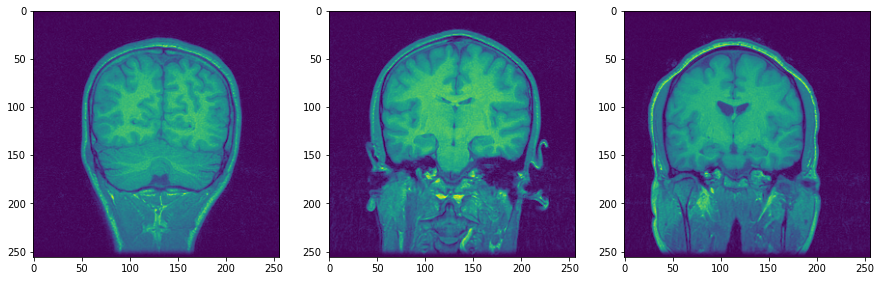

In [ ]:
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,10))
ax0.imshow(data[30])
ax1.imshow(data[60])
ax2.imshow(data[789])

In [ ]:
from torchvision.transforms import InterpolationMode

tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(45, (0.2,0.2), (0.6,0.9), 5, InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.1408],[0.1716])
])


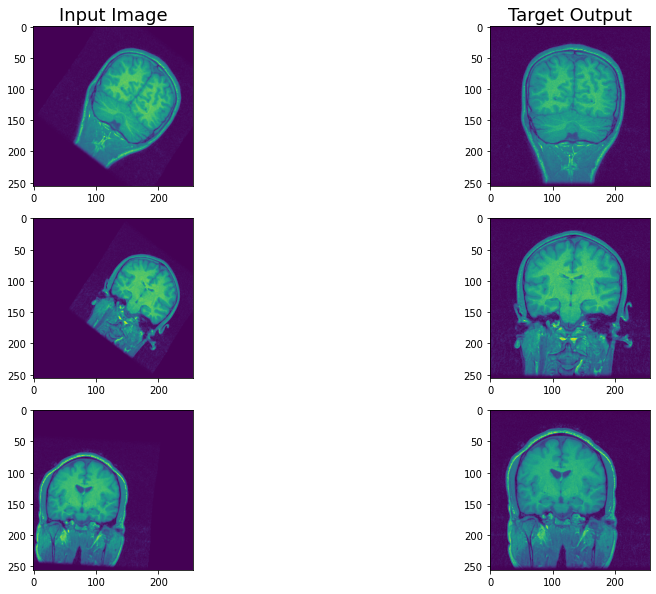

In [ ]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space",tfms)
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,10))
ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(data[30][0].numpy().squeeze())
ax1[0].imshow(data[60][0].numpy().squeeze())
ax2[0].imshow(data[789][0].numpy().squeeze())

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(data[30][1].numpy().squeeze())
ax1[1].imshow(data[60][1].numpy().squeeze())
ax2[1].imshow(data[789][1].numpy().squeeze())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bs = 32
dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
a=next(iter(dl))
a[0].shape, a[1].shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 256, 256]))

In [ ]:
a[0].mean(), a[0].std(), a[0].max()

(tensor(-0.2397), tensor(1.0380), tensor(4.9558))

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        # A final layer to adjust for interpolation
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        
        res_out = self.conv1(x)
        x = x + res_out
        
        return x

model = Net(256).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005)

loss_fn = nn.L1Loss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50*bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl.dataset),
                100. * batch_idx / len(dl), loss.item()))


In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # A batch of training data
        data = next(iter(dl))
        moving, target = data[0].to(device), data[1].cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor = model(moving).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target[:,None]))
        
        # Plot of the results side-by-side
        f, axarr = plt.subplots(3, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Output Images')
        
        axarr[2].imshow(target_grid)
        axarr[2].set_title('Target Images')

In [ ]:
for epoch in range(1, 20):
    train(epoch)

Train Epoch: 1 [0/4800 (0%)]	Loss: 0.898944
Train Epoch: 1 [1600/4800 (33%)]	Loss: 0.793673
Train Epoch: 1 [3200/4800 (67%)]	Loss: 0.801100
Train Epoch: 2 [0/4800 (0%)]	Loss: 0.756131
Train Epoch: 2 [1600/4800 (33%)]	Loss: 0.786177
Train Epoch: 2 [3200/4800 (67%)]	Loss: 0.799234
Train Epoch: 3 [0/4800 (0%)]	Loss: 0.845666
Train Epoch: 3 [1600/4800 (33%)]	Loss: 0.800127
Train Epoch: 3 [3200/4800 (67%)]	Loss: 0.798202
Train Epoch: 4 [0/4800 (0%)]	Loss: 0.754220
Train Epoch: 4 [1600/4800 (33%)]	Loss: 0.722196
Train Epoch: 4 [3200/4800 (67%)]	Loss: 0.746270
Train Epoch: 5 [0/4800 (0%)]	Loss: 0.689964
Train Epoch: 5 [1600/4800 (33%)]	Loss: 0.720850
Train Epoch: 5 [3200/4800 (67%)]	Loss: 0.700275
Train Epoch: 6 [0/4800 (0%)]	Loss: 0.713538
Train Epoch: 6 [1600/4800 (33%)]	Loss: 0.692611
Train Epoch: 6 [3200/4800 (67%)]	Loss: 0.702255
Train Epoch: 7 [0/4800 (0%)]	Loss: 0.683486
Train Epoch: 7 [1600/4800 (33%)]	Loss: 0.700894
Train Epoch: 7 [3200/4800 (67%)]	Loss: 0.724102
Train Epoch: 8 [0/48

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([24, 256, 256])) that is different to the input size (torch.Size([24, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [ ]:
def test_train():
    model = Net()
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
    dl = torch.utils.data.DataLoader(test_dl, batch_size=32, shuffle=True)
    loss_fn = nn.MSELoss()

    for epoch in range(5):
        train_loss, train_mask_acc, train_jaccard, train_mi = train(epoch)
        assert isinstance(train_loss, float), "train_loss should be a float"
        assert isinstance(train_mask_acc, float), "train_mask_acc should be a float"
        assert isinstance(train_jaccard, float), "train_jaccard should be a float"
        assert isinstance(train_mi, float), "train_mi should be a float"
        assert train_loss >= 0, "train_loss should be non-negative"
        assert 0 <= train_mask_acc <= 100, "train_mask_acc should be between 0 and 100"
        assert 0 <= train_jaccard <= 1, "train_jaccard should be between 0 and 1"
        assert train_mi >= 0, "train_mi should be non-negative"

In [ ]:
%%time
for epoch in range(1, 6):
    test()


In [ ]:
def test():
    model.eval()
    total_loss = 0
    total_mask_accuracy = 0
    total_jaccard = 0
    total_mi = 0
    total_batches = len(test_dl)
    with torch.no_grad():
        for batch_idx, (data, target, input_mask, target_mask) in enumerate(test_dl):
            data, target = data.to(device), target.to(device)
            input_mask, target_mask = input_mask.to(device), target_mask.to(device)

            output_image, output_mask = model(data, input_mask)

            loss = loss_fn(output_image, target)

            total_loss += loss.item()
            total_mask_accuracy += accuracy(output_mask, target_mask).item() * 100
            total_jaccard += jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu())
            total_mi += mutual_information(output_image.detach().cpu(), target.detach().cpu())

            if batch_idx == 0:
                print(f'Test Batch {batch_idx}:\t Loss: {round(loss.item(),4)}\t Mask accuracy: {round(accuracy(output_mask,target_mask).item()*100,2)}%\t Jaccard: {round(jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu()),4)}\t MI: {round(mutual_information(output_image.detach().cpu(), target.detach().cpu()), 4)}')

    average_loss = total_loss / total_batches
    average_mask_accuracy = total_mask_accuracy / total_batches
    average_jaccard = total_jaccard / total_batches
    average_mi = total_mi / total_batches
    print(f'Test Results:\t Average Loss: {round(average_loss,4)}\t Average Mask accuracy: {round(average_mask_accuracy,2)}%\t Average Jaccard: {round(average_jaccard,4)}\t Average MI: {round(average_mi,4)}')

In [ ]:
def test():
    model.eval()
    test_loss = 0
    accuracy_total = 0
    jaccard_total = 0
    mi_total = 0
    with torch.no_grad():
        for batch_idx, (data, target, input_mask, target_mask) in enumerate(test_dl):
            data, target = data.to(device), target.to(device)
            input_mask, target_mask = input_mask.to(device), target_mask.to(device)

            # apply the same transformation to the test data as the training data
            data = TF.resize(data, (256, 256))
            target = TF.resize(target, (256, 256))
            input_mask = TF.resize(input_mask, (256, 256))
            target_mask = TF.resize(target_mask, (256, 256))
            
            output_image, output_mask = model(data, input_mask)
            total_loss += loss.item()
            total_mask_accuracy += accuracy(output_mask,target_mask).item()*100
            total_jaccard += jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu())
            total_mi += mutual_information(output_image.detach().cpu(), target.detach().cpu())
    average_loss = total_loss / total_batches
    average_mask_accuracy = total_mask_accuracy / total_batches
    average_jaccard = total_jaccard / total_batches
    average_mi = total_mi / total_batches
    print(f'Train Epoch {epoch}:\t Average Loss: {round(average_loss,4)}\t Average Mask accuracy: {round(average_mask_accuracy,2)}%\t Average Jaccard: {round(average_jaccard,4)}\t Average MI: {round(average_mi,4)}')
    
    return average_loss, average_mask_accuracy, average_jaccard, average_mi

In [ ]:
visualize_stn()

FileNotFoundError: ignored